In [1]:
import os
import glob

# Path to your dataset folder
# Each class should be in a separate folder inside this directory
dataset_path = "dataset"

# List all subfolders (classes)
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

print("Found classes:", classes)
print("Total classes:", len(classes))
# Count images in each class
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    # Assuming common image extensions
    image_files = glob.glob(os.path.join(class_path, "*.[pjPJ]*[ngNG]*"))  # jpg, jpeg, png
    print(f"Class '{cls}' has {len(image_files)} images")


Found classes: ['Acne And Rosacea Photos', 'Malignant', 'Fu Athlete Foot', 'Eczema Photos', 'Fu Ringworm', 'Benign', 'Exanthems And Drug Eruptions', 'Lupus And Other Connective Tissue Diseases', 'Ba Impetigo', 'Bullous Disease Photos', 'Nail Fungus And Other Nail Disease', 'Light Diseases And Disorders Of Pigmentation', 'Atopic Dermatitis Photos', 'Actinic Keratosis Basal Cell Carcinoma And Other Malignant Lesions', 'Melanoma Skin Cancer Nevi And Moles', 'Cellulitis Impetigo And Other Bacterial Infections', 'Hair Loss Photos Alopecia And Other Hair Diseases', 'Herpes Hpv And Other Stds Photos', 'Fu Nail Fungus', 'Ba  Cellulitis']
Total classes: 20
Class 'Acne And Rosacea Photos' has 6837 images
Class 'Malignant' has 6762 images
Class 'Fu Athlete Foot' has 8054 images
Class 'Eczema Photos' has 6715 images
Class 'Fu Ringworm' has 8129 images
Class 'Benign' has 6459 images
Class 'Exanthems And Drug Eruptions' has 7750 images
Class 'Lupus And Other Connective Tissue Diseases' has 7734 imag

In [2]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [3]:
import os

# Suppress TensorFlow Python logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Suppress ML Compute / Metal debug info
os.environ["TF_METAL_ENABLE_LOGGING"] = "0"
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"

import tensorflow as tf
tf.debugging.set_log_device_placement(False)


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

In [5]:
DATA_ROOT = "dataset"   # <-- change to your dataset folder
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
VAL_SPLIT = 0.15
SEED = 1337

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_ROOT,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes: {num_classes}")

Found 150686 files belonging to 20 classes.
Using 128084 files for training.
Found 150686 files belonging to 20 classes.
Using 22602 files for validation.
Classes: 20


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

In [9]:
base_model = keras.applications.EfficientNetB0(
    include_top=False,
    weights="weights_mobilenet_v3_large_224_1.0_float_no_top_v2.h5",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling="avg",
)

In [10]:
base_model.trainable = False  # freeze for transfer learning

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)


In [11]:
model = keras.Model(inputs, outputs)

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)


In [13]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2),
]

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/15
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 2459s 608ms/step - accuracy: 0.5545 - loss: 1.4807 - val_accuracy: 0.6543 - val_loss: 1.1290 - learning_rate: 3.0000e-04
Epoch 2/15
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 2413s 597ms/step - accuracy: 0.6361 - loss: 1.1659 - val_accuracy: 0.6763 - val_loss: 1.0278 - learning_rate: 3.0000e-04
Epoch 3/15
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 2408s 594ms/step - accuracy: 0.6526 - loss: 1.0976 - val_accuracy: 0.6974 - val_loss: 0.9741 - learning_rate: 3.0000e-04
Epoch 4/15
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 2396s 592ms/step - accuracy: 0.6620 - loss: 1.0606 - val_accuracy: 0.7052 - val_loss: 0.9383 - learning_rate: 3.0000e-04
Epoch 5/15
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 2385s 589ms/step - accuracy: 0.6650 - loss: 1.0432 - val_accuracy: 0.7103 - val_loss: 0.9169 - learning_rate: 3.0000e-04
Epoch 6/15
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 2374s 586ms/step - accuracy: 0.6697 - loss: 1.0279 - val_accuracy: 0.7137 - val_loss: 0.9021 - learning_rate: 3.0000e-04
Epoch 7/15
4003/4003 ━

In [15]:
base_model.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

fine_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks,
)

Epoch 1/5
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 15234s 4s/step - accuracy: 0.5478 - loss: 1.4910 - val_accuracy: 0.6746 - val_loss: 1.0025 - learning_rate: 1.0000e-05
Epoch 2/5
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 13007s 3s/step - accuracy: 0.6793 - loss: 0.9879 - val_accuracy: 0.7359 - val_loss: 0.8214 - learning_rate: 1.0000e-05
Epoch 3/5
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 15136s 4s/step - accuracy: 0.7356 - loss: 0.8125 - val_accuracy: 0.7744 - val_loss: 0.7046 - learning_rate: 1.0000e-05
Epoch 4/5
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 18158s 5s/step - accuracy: 0.7761 - loss: 0.6863 - val_accuracy: 0.7987 - val_loss: 0.6200 - learning_rate: 1.0000e-05
Epoch 5/5
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 17254s 4s/step - accuracy: 0.8073 - loss: 0.5867 - val_accuracy: 0.8284 - val_loss: 0.5334 - learning_rate: 1.0000e-05


In [16]:
model.save("skin_disease_model_tf.h5")
model.save("skin_disease_model_tf.keras")

In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load your model
model = load_model('skin_disease_model_tf.keras')

# Check the model summary to ensure it's loaded correctly
model.summary()


2025-08-30 14:01:55.239045: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-08-30 14:01:55.239086: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-30 14:01:55.239095: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-08-30 14:01:55.239145: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-30 14:01:55.239163: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Volumes/CrucialX9/Project/venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 215 variab

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │        25,620 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,108,361 (30.93 MB)

 Trainable params: 4,033,168 (15.39 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 4,033,170 (15.39 MB)

In [12]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(path):
    img = load_img(path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # batch dimension
    img_array = keras.applications.efficientnet.preprocess_input(img_array)

    preds = model.predict(img_array)
    predicted_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)
    print(f"Prediction: {predicted_class} ({confidence*100:.2f}%)")

predict_image("dataset/Ba  Cellulitis/aug_0_BA- cellulitis (96).jpg")


2025-08-30 14:02:18.671879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Prediction: Eczema Photos (100.00%)


In [34]:
import os
import random
import numpy as np
import pandas as pd
from tensorflow.keras.utils import load_img, img_to_array
import keras  # make sure keras or tensorflow.keras is imported

DATA_ROOT = "dataset"   # your dataset root
N_SAMPLES_PER_FOLDER = 40
IMG_SIZE = 224  # set your image size
class_names = ['Acne And Rosacea Photos', 'Malignant', 'Fu Athlete Foot', 'Eczema Photos', 'Fu Ringworm', 'Benign', 'Exanthems And Drug Eruptions', 'Lupus And Other Connective Tissue Diseases', 'Ba Impetigo', 'Bullous Disease Photos', 'Nail Fungus And Other Nail Disease', 'Light Diseases And Disorders Of Pigmentation', 'Atopic Dermatitis Photos', 'Actinic Keratosis Basal Cell Carcinoma And Other Malignant Lesions', 'Melanoma Skin Cancer Nevi And Moles', 'Cellulitis Impetigo And Other Bacterial Infections', 'Hair Loss Photos Alopecia And Other Hair Diseases', 'Herpes Hpv And Other Stds Photos', 'Fu Nail Fungus', 'Ba  Cellulitis']

# model = ...  # load your trained model here

# Collect all (folder_name, file_path) pairs per folder
sampled = []
for folder_name in os.listdir(DATA_ROOT):
    folder_path = os.path.join(DATA_ROOT, folder_name)
    if os.path.isdir(folder_path):
        files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        # Randomly pick N_SAMPLES_PER_FOLDER images from this folder
        sampled_files = random.sample(files, min(N_SAMPLES_PER_FOLDER, len(files)))
        for f in sampled_files:
            sampled.append((folder_name, f))

# Prediction function
def predict_image(path):
    img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = keras.applications.efficientnet.preprocess_input(img_array)
    preds = model.predict(img_array, verbose=0)
    pred_class = class_names[np.argmax(preds)]
    confidence = float(np.max(preds))
    return pred_class, confidence

# Run predictions
results = []
for folder_name, filepath in sampled:
    pred_class, conf = predict_image(filepath)
    results.append({
        "Folder_Name": folder_name,       # true class (folder)
        "Predicted_Class": pred_class,    # model output
        "Confidence": conf,
        "File": os.path.basename(filepath)
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results

# Optional: Save to CSV
# df_results.to_csv("sample_predictions.csv", index=False)


,Folder_Name,Predicted_Class,Confidence,File
0,Acne And Rosacea Photos,Acne And Rosacea Photos,0.846680,aug_2786_acne-open-comedo-37.jpg
1,Acne And Rosacea Photos,Lupus And Other Connective Tissue Diseases,0.245117,aug_2185_acne-excoriated-16.jpg
2,Acne And Rosacea Photos,Acne And Rosacea Photos,0.881836,acne-closed-comedo-14.jpg
3,Acne And Rosacea Photos,Acne And Rosacea Photos,0.240112,aug_5059_rosacea-40.jpg
4,Acne And Rosacea Photos,Fu Athlete Foot,0.292480,aug_1640_Sebaceous-glands-Areola-1.jpg
...,...,...,...,...
795,Ba Cellulitis,Eczema Photos,1.000000,aug_5075_BA- cellulitis (1).jpg
796,Ba Cellulitis,Eczema Photos,1.000000,aug_3107_BA- cellulitis (68).jpg
797,Ba Cellulitis,Eczema Photos,0.997070,aug_409_BA- cellulitis (105).jpg
798,Ba Cellulitis,Eczema Photos,1.000000,aug_257_BA- cellulitis (65).jpg


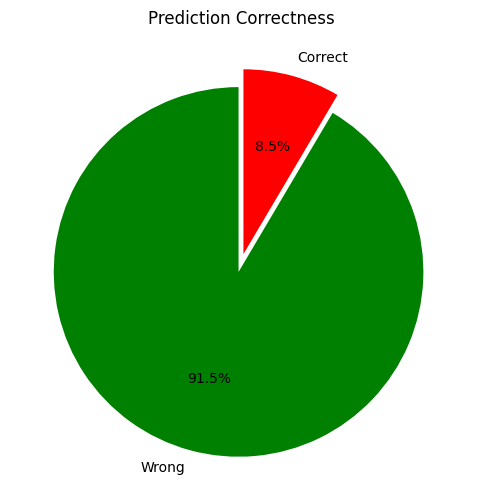

In [39]:
import pandas as pd
import matplotlib.pyplot as plt



# Create a column for correct/incorrect
df_results['Result'] = df_results.apply(
    lambda x: 'Correct' if x['Folder_Name'].lower() == x['Predicted_Class'].lower() else 'Wrong', axis=1
)

# Count correct and wrong predictions
counts = df_results['Result'].value_counts()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=['green','red'], startangle=90, explode=[0.05, 0.05])
plt.title('Prediction Correctness')
plt.show()


In [40]:
round(df_results[df_results["Confidence"] >.5]["Confidence"],1).value_counts()

Confidence
1.0    330
0.9    115
0.8     69
0.6     60
0.7     55
0.5     30
Name: count, dtype: int64

In [41]:
df_results

,Folder_Name,Predicted_Class,Confidence,File,Result
0,Acne And Rosacea Photos,Acne And Rosacea Photos,0.846680,aug_2786_acne-open-comedo-37.jpg,Correct
1,Acne And Rosacea Photos,Lupus And Other Connective Tissue Diseases,0.245117,aug_2185_acne-excoriated-16.jpg,Wrong
2,Acne And Rosacea Photos,Acne And Rosacea Photos,0.881836,acne-closed-comedo-14.jpg,Correct
3,Acne And Rosacea Photos,Acne And Rosacea Photos,0.240112,aug_5059_rosacea-40.jpg,Correct
4,Acne And Rosacea Photos,Fu Athlete Foot,0.292480,aug_1640_Sebaceous-glands-Areola-1.jpg,Wrong
...,...,...,...,...,...
795,Ba Cellulitis,Eczema Photos,1.000000,aug_5075_BA- cellulitis (1).jpg,Wrong
796,Ba Cellulitis,Eczema Photos,1.000000,aug_3107_BA- cellulitis (68).jpg,Wrong
797,Ba Cellulitis,Eczema Photos,0.997070,aug_409_BA- cellulitis (105).jpg,Wrong
798,Ba Cellulitis,Eczema Photos,1.000000,aug_257_BA- cellulitis (65).jpg,Wrong


In [43]:
df_results[(df_results["Result"] == "Wrong") & (df_results["Confidence"] == 1.0)]["Folder_Name"].count()



143